# Deep learning Assessment- Transfer Learning <br>

In [1]:
!pip install matplotlib

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import ViT_B_16_Weights, vit_b_16
from torchvision.datasets import ImageFolder
from PIL import Image

import time
import os
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

In [40]:
#the size of our mini batches
batch_size     = 128
#How many iterations of our dataset
num_epochs     = 10
#optimizer learning rate
learning_rate  = 1e-4
#initialise what epoch we start from
start_epoch    = 0
#initialise best valid accuracy 
best_valid_acc = 0
#where to load/save the dataset from 
data_set_root  = "data"
#what to resize our images to 
image_size     = 64

In [41]:
save_checkpoint = False
start_from_checkpoint = False
save_dir = 'Models'
model_name = 'Res_18_STL10'

In [42]:
#Set device to GPU_indx if GPU is avaliable
device = torch.device("mps" if torch.torch.backends.mps.is_available() else 'cpu')

In [43]:
print(device)

mps


# Some preprocess to the dataset. eg: Convert the images to tensor

# Data Augmentation Transform<br>

In [44]:
# Prepare a composition of transforms
# Replace the Resize in the above transform with two random transforms
# https://pytorch.org/docs/stable/torchvision/transforms.html
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(num_output_channels=3), 
    transforms.RandomAffine(degrees=15, scale=(1.0, 1.2), fill=0),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

In [45]:
dataset = ImageFolder(root="dataset_2/train_images", transform=transform)

In [46]:
len(dataset)

43526

# Create the training, testing and validation data 

In [47]:
# Split trainting data into train and validation set with 80/20% traning/validation split
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15
n_total = len(dataset)

n_train = int(train_ratio * n_total)
n_valid = int(valid_ratio * n_total)
n_test = n_total - n_train - n_valid  

# Split dataset
train, valid_data, test = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])

# Check the lengths of all the datasets

In [48]:
print(f'Number of training examples: {len(train)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test)}')


Number of training examples: 30468
Number of validation examples: 6528
Number of testing examples: 6530


mildly_demented: 10396 images
moderatly_demented: 9690 images
non_demented: 12200 images
very_mildly_demented: 11240 images


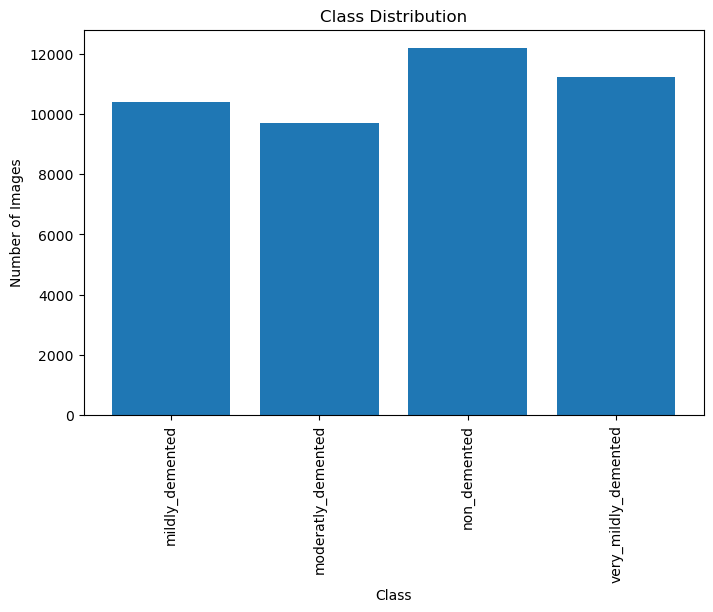

In [49]:
# Get class names
class_names = dataset.classes

# Count the number of samples per class
class_counts = Counter(dataset.targets)

# Print counts
for idx, count in class_counts.items():
    print(f"{class_names[idx]}: {count} images")

# Optional: Bar chart
plt.figure(figsize=(8,5))
plt.bar(class_names, [class_counts[i] for i in range(len(class_names))])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.savefig("class_distribution.png", dpi=300, bbox_inches='tight')  # Save as PNG with high quality
plt.show()

In [50]:
os.getcwd()

'/Users/oluwasogoadeleke/Downloads'

# Create the dataloader

In [51]:
#Create the training, Validation and Evaluation/Test Datasets
#It is best practice to separate your data into these three Datasets
#Though depending on your task you may only need Training + Evaluation/Test or maybe only a Training set
#(It also depends on how much data you have)
#https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [52]:
#This Function will allow us to scale an images pixel values to a value between 0 and 1
def normalize_img(img):
    mins = img.min(0, keepdims = True).min(1, keepdims = True)
    maxs = img.max(0, keepdims = True).max(1, keepdims = True)
    return (img - mins)/(maxs - mins)

# Visualise the data <br>
It is always important to fully understand what you are training your network with

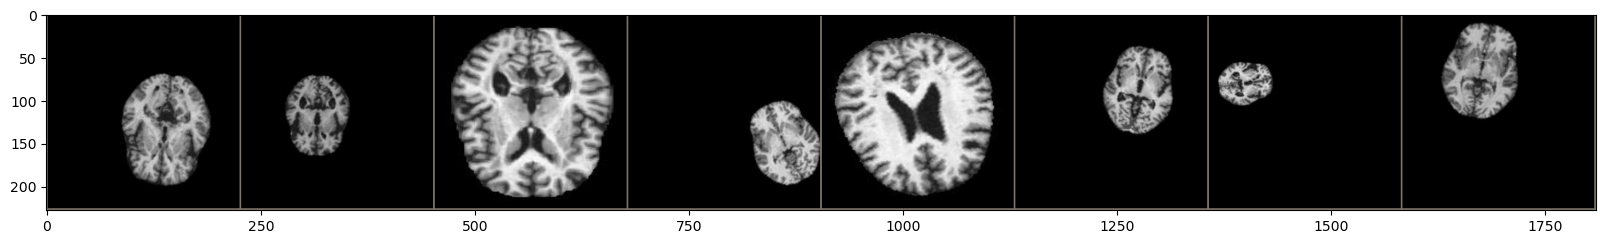

In [53]:
plt.figure(figsize = (20,10))
images, labels = next(iter(train_dataloader))
out = torchvision.utils.make_grid(images[0:8])
plt.imshow(normalize_img(out.numpy().transpose((1, 2, 0))))

# Create the pretrained network <br>


In [54]:
#Model No: 1
#Create a ResNet18 from the pytorch "models" module, load the weight and update the last layer.
#This is reasonably sized model at 18 layers deep
#ResNet Paper https://arxiv.org/pdf/1512.03385.pdf
weights = ResNet18_Weights.DEFAULT
Res_net = resnet18(weights=weights)
Res_net.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = Res_net.fc.in_features
num_classes = len(train.dataset.classes)
Res_net.fc = nn.Linear(num_ftrs, num_classes) 
Res_net = Res_net.to(device)

# To unfreeze layers
for param in Res_net.parameters():
    param.requires_grad = True 

Lets see the structure of this network

In [55]:
#view the network
Res_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The ImageNet challange dataset that the ResNet model was trained on has 1000 classes but the STL10 dataset only has 10 <br>
We can still use the pretrained model we just need to alter it a bit by simply replacing the last FC (linear) layer with a new one 

In [56]:
#pass image through network
out = Res_net(images.to(device))
#check output
out.shape

torch.Size([128, 4])

# Set up the optimizer 

In [57]:
#Pass our network parameters to the optimiser set our lr as the learning_rate
optimizer = optim.Adam(Res_net.parameters(), lr = learning_rate)

In [58]:
#Define a Cross Entropy Loss
Loss_fun = nn.CrossEntropyLoss()

# Loading Checkpoints

In [59]:
#Create Save Path from save_dir and model_name, we will save and load our checkpoint here
save_path = os.path.join(save_dir, model_name + ".pt")

#Create the save directory if it does note exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

#Load Checkpoint
if start_from_checkpoint:
    #Check if checkpoint exists
    if os.path.isfile(save_path):
        #load Checkpoint
        check_point = torch.load(save_path)
        #Checkpoint is saved as a python dictionary
        #https://www.w3schools.com/python/python_dictionaries.asp
        #here we unpack the dictionary to get our previous training states
        Res_net.load_state_dict(check_point['model_state_dict'])
        optimizer.load_state_dict(check_point['optimizer_state_dict'])
        start_epoch = check_point['epoch']
        best_valid_acc = check_point['valid_acc']
        print("Checkpoint loaded, starting from epoch:", start_epoch)
    else:
        #Raise Error if it does not exist
        raise ValueError("Checkpoint Does not exist")
else:
    #If checkpoint does exist and Start_From_Checkpoint = False
    #Raise an error to prevent accidental overwriting
    if os.path.isfile(save_path):
        raise ValueError("Warning Checkpoint exists")
    else:
        print("Starting from scratch")

Starting from scratch


# Define the accuracy calculator

In [60]:
def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

# Define the training process

In [61]:
#This function should perform a single training epoch using our training data
def train(net, device, loader, optimizer, loss_fun, loss_logger):
    
    #initialise counters
    epoch_loss = 0
    epoch_acc = 0
    
    #Set Network in train mode
    net.train()
    
    for i, (x, y) in enumerate(loader):
        
        #load images and labels to device
        x = x.to(device) # x is the image
        y = y.to(device) # y is the corresponding label
                
        #Forward pass of image through network and get output
        fx = net(x)
        
        #Calculate loss using loss function
        loss = loss_fun(fx, y)
        
        #calculate the accuracy
        acc = calculate_accuracy(fx, y)

        #Zero Gradents
        optimizer.zero_grad()
        #Backpropagate Gradents
        loss.backward()
        #Do a single optimization step
        optimizer.step()
        
        #create the cumulative sum of the loss and acc
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #log the loss for plotting
        loss_logger.append(loss.item())

        #clear_output is a handy function from the IPython.display module
        #it simply clears the output of the running cell
        
        clear_output(True)
        print("TRAINING: | Itteration [%d/%d] | Loss %.2f |" %(i+1 ,len(loader) , loss.item()))
        
    #return the avaerage loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger

# Define the testing process

In [62]:
#This function should perform a single evaluation epoch and will be passed our validation or evaluation/test data
#it WILL NOT be used to train out model
def evaluate(net, device, loader, loss_fun, loss_logger = None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    net.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            
            #load images and labels to device
            x = x.to(device)
            y = y.to(device)
            
            #Forward pass of image through network
            fx = net(x)
            
            #Calculate loss using loss function
            loss = loss_fun(fx, y)
            
            #calculate the accuracy
            acc = calculate_accuracy(fx, y)
            
            #log the cumulative sum of the loss and acc
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            #log the loss for plotting if we passed a logger to the function
            if not (loss_logger is None):
                loss_logger.append(loss.item())
            
            clear_output(True)
            print("EVALUATION: | Itteration [%d/%d] | Loss %.2f | Accuracy %.2f%% |" %(i+1 ,len(loader), loss.item(), 100*(epoch_acc/ len(loader))))
    
    #return the avaerage loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger

<h3> Learning rate schedular </h3>


In [63]:
#Create a function that will linearly decay the learning rate every epoch
def lr_linear_decay(epoch_max, epoch, lr):
    lr_adj = ((epoch_max - epoch)/epoch_max)*lr
    #update the learning rate parameter of the optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_adj

# The training process <br>
You should record the training and evaluation accuracy as well as the training time after every experiment! 

In [64]:
#Log the training and validation losses
training_loss_logger = []
validation_loss_logger = []
print(device)

mps


In [65]:
#This cell implements our training loop

#Record the start time
Start_time = time.time()

for epoch in range(start_epoch, num_epochs):
    #Implement the linear decay of the learning rate
    lr_linear_decay(num_epochs, epoch, learning_rate)
    
    #call the training function and pass training dataloader etc
    train_loss, train_acc, training_loss_logger = train(Res_net, device, train_dataloader, optimizer, Loss_fun, training_loss_logger)
    
    #call the evaluate function and pass validation dataloader etc
    valid_loss, valid_acc, validation_loss_logger = evaluate(Res_net, device, valid_loader, Loss_fun, validation_loss_logger)

    #If this model has the highest performace on the validation set 
    #then save a checkpoint
    #{} define a dictionary, each entry of the dictionary is indexed with a string
    if (valid_acc > best_valid_acc) and save_checkpoint:
        print("Saving Model")
        torch.save({
            'epoch':                 epoch,
            'model_state_dict':      Res_net.state_dict(),
            'optimizer_state_dict':  optimizer.state_dict(), 
            'train_acc':             train_acc,
            'valid_acc':             valid_acc,
        }, save_path)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')

End_time = time.time()

EVALUATION: | Itteration [51/51] | Loss 0.03 | Accuracy 97.70% |
| Epoch: 10 | Train Loss: 0.047 | Train Acc: 98.50% | Val. Loss: 0.062 | Val. Acc: 97.70% |


In [70]:
print("Training time %.2f seconds" %(End_time - Start_time))

Training time 1501.83 seconds


Res_net Accuracy:  0.9769
Res_net Precision: 0.9777
Res_net Recall:    0.9775
Res_net F1 Score:  0.9776
Res_net AUC:       0.9988


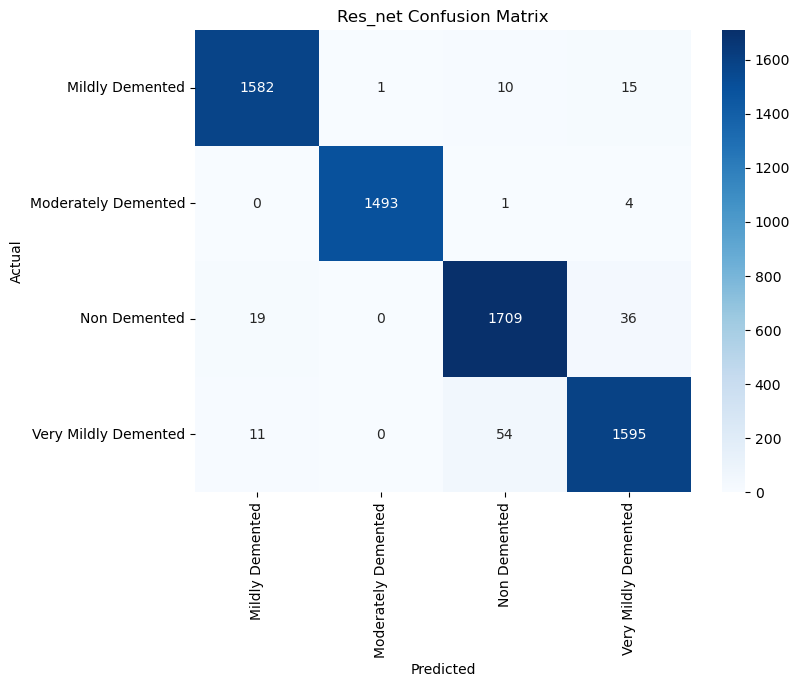

In [69]:
Res_net.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = Res_net(inputs)
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_probs = np.array(all_probs)

# Binarize the true labels for AUC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')

# Print metrics
print(f"Res_net Accuracy:  {accuracy:.4f}")
print(f"Res_net Precision: {precision:.4f}")
print(f"Res_net Recall:    {recall:.4f}")
print(f"Res_net F1 Score:  {f1:.4f}")
print(f"Res_net AUC:       {auc:.4f}")

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
class_names = ['Mildly Demented', 'Moderately Demented', 'Non Demented', 'Very Mildly Demented']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Res_net Confusion Matrix')
plt.savefig("ResNetCM.png", dpi=300, bbox_inches='tight')  
plt.show()

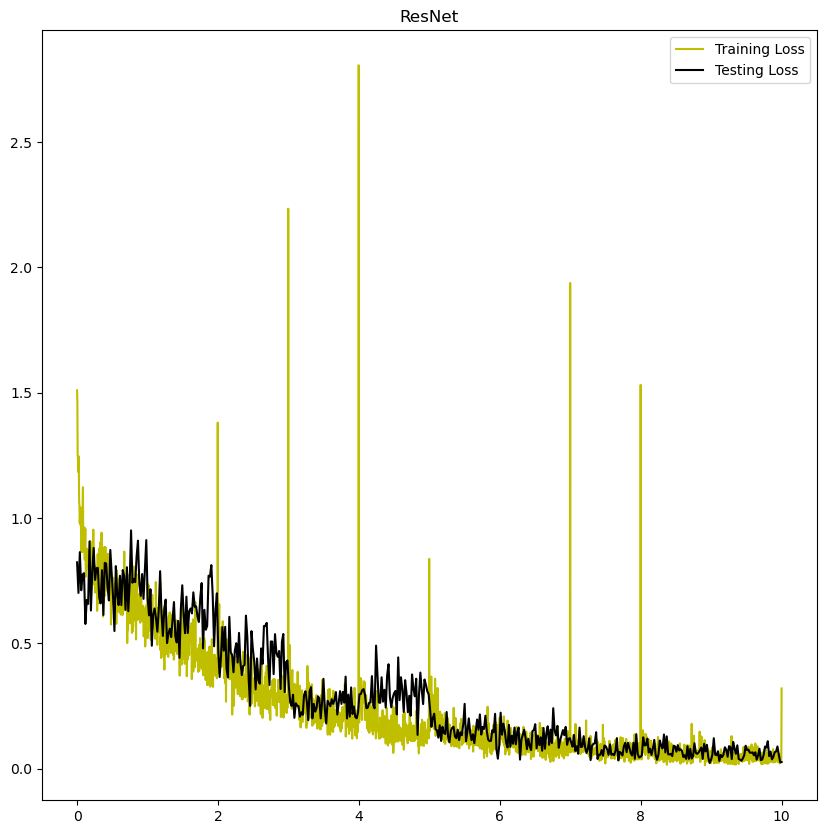

In [67]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_loss_logger))
plt.plot(valid_x, validation_loss_logger, c = "k")

plt.title("ResNet")
plt.legend(["Training Loss", "Testing Loss"])
plt.savefig("ResNet.png", dpi=300, bbox_inches='tight')  # Save as PNG with high quality


In [71]:
#Model 2  - Efficientnet

# Load pretrained EfficientNet-B0
weights = EfficientNet_B0_Weights.DEFAULT
efficientnet_model = efficientnet_b0(weights=weights)

# Replacing classifier for 4 classes
in_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(in_features, 4)
efficientnet_model = efficientnet_model.to(device)

# Unfreezing layers
for param in efficientnet_model.parameters():
    param.requires_grad = True 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_model.parameters(), lr=learning_rate)

# -------------------------------
# Training Loop
# -------------------------------
#Record the start time
Start_time = time.time()

for epoch in range(start_epoch, num_epochs):
    #Implement the linear decay of the learning rate
    lr_linear_decay(num_epochs, epoch, learning_rate)
    
    #call the training function and pass training dataloader etc
    train_loss, train_acc, training_loss_logger = train(efficientnet_model, device, train_dataloader, optimizer, criterion, training_loss_logger)
    
    #call the evaluate function and pass validation dataloader etc
    valid_loss, valid_acc, validation_loss_logger = evaluate(efficientnet_model, device, valid_loader, criterion, validation_loss_logger)

    #If this model has the highest performace on the validation set 
    #then save a checkpoint
    #{} define a dictionary, each entry of the dictionary is indexed with a string
    if (valid_acc > best_valid_acc) and save_checkpoint:
        print("Saving Model")
        torch.save({
            'epoch':                 epoch,
            'model_state_dict':      efficientnet_model.state_dict(),
            'optimizer_state_dict':  optimizer.state_dict(), 
            'train_acc':             train_acc,
            'valid_acc':             valid_acc,
        }, save_path)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')

End_time = time.time()

EVALUATION: | Itteration [51/51] | Loss 0.06 | Accuracy 96.72% |
| Epoch: 10 | Train Loss: 0.113 | Train Acc: 95.53% | Val. Loss: 0.086 | Val. Acc: 96.72% |


In [72]:
print("Training time %.2f seconds" %(End_time - Start_time))

Training time 4664.92 seconds


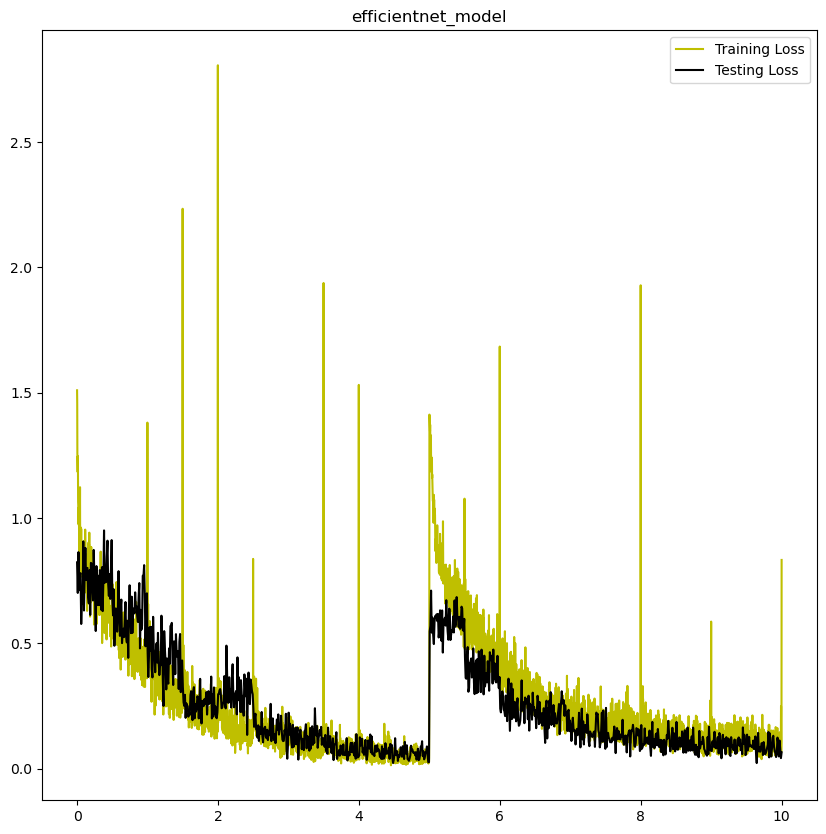

In [73]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_loss_logger))
plt.plot(valid_x, validation_loss_logger, c = "k")

plt.title("efficientnet_model")
plt.legend(["Training Loss", "Testing Loss"])
plt.savefig("efficientnet_model.png", dpi=300, bbox_inches='tight')


In [75]:
efficientnet_model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = efficientnet_model(inputs)
        probs = torch.softmax(outputs, dim=1)  
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_probs = np.array(all_probs)

# Binarize true labels for multiclass AUC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Compute metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')

# Print metrics
print(f"EfficientNet_model Accuracy:  {accuracy:.4f}")
print(f"EfficientNet_model Precision: {precision:.4f}")
print(f"EfficientNet_model Recall:    {recall:.4f}")
print(f"EfficientNet_model F1 Score:  {f1:.4f}")
print(f"EfficientNet_model AUC:       {auc:.4f}")

EfficientNet_model Accuracy:  0.9665
EfficientNet_model Precision: 0.9676
EfficientNet_model Recall:    0.9673
EfficientNet_model F1 Score:  0.9674
EfficientNet_model AUC:       0.9983


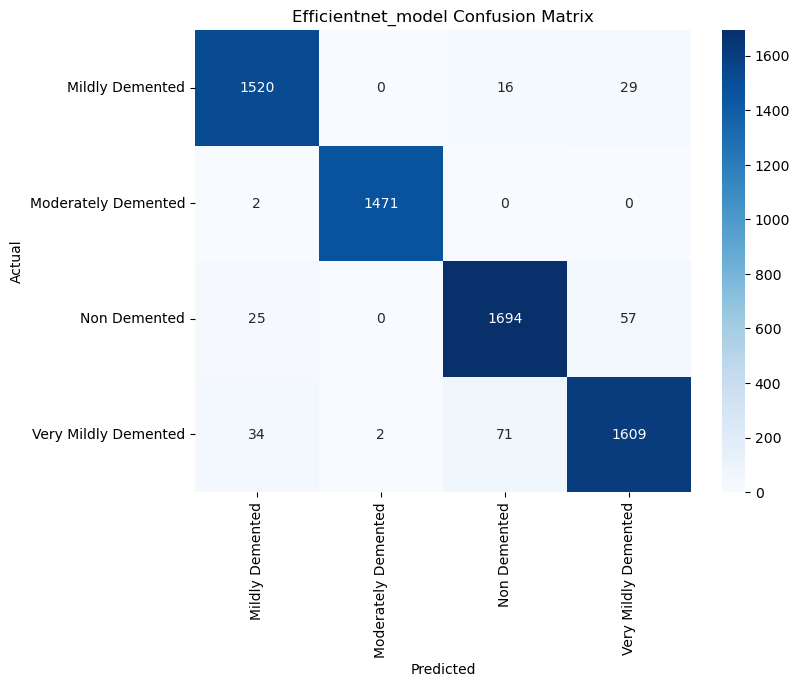

In [31]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
class_names = ['Mildly Demented', 'Moderately Demented', 'Non Demented', 'Very Mildly Demented']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Efficientnet_model Confusion Matrix')
plt.savefig("Eff_confusion_matrix.png", dpi=300, bbox_inches='tight') 
plt.show()

In [32]:
# Model 4 - Vision Transformers

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
# === DATASET 
train_new = ImageFolder(root="dataset_2/train_images", transform=transform)

train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15
n_total = len(train_new)

n_train = int(train_ratio * n_total)
n_valid = int(valid_ratio * n_total)
n_test = n_total - n_train - n_valid  # To avoid rounding issues

# Split dataset
train, valid_data, test = torch.utils.data.random_split(train_new, [n_train, n_valid, n_test])

# DATALOADER ===
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

# Define device
device = torch.device("mps" if torch.torch.backends.mps.is_available() else 'cpu')

# Loading pretrained Vision Transformer
weights = ViT_B_16_Weights.DEFAULT
vit_model = vit_b_16(weights=weights)

# Get the input features of the final classification layer
in_features = vit_model.heads[0].in_features

# Replace the classification head with a new Linear layer for 4 classes
vit_model.heads = nn.Sequential(nn.Linear(in_features, 4))

# Move model to device
vit_model = vit_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=learning_rate)

#Create Save Path from save_dir and model_name, we will save and load our checkpoint here
save_path = os.path.join(save_dir, model_name + ".pt")

#Create the save directory if it does note exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

#Load Checkpoint
if start_from_checkpoint:
    #Check if checkpoint exists
    if os.path.isfile(save_path):
        #load Checkpoint
        check_point = torch.load(save_path)
        #Checkpoint is saved as a python dictionary
        #https://www.w3schools.com/python/python_dictionaries.asp
        #here we unpack the dictionary to get our previous training states
        vit_model.load_state_dict(check_point['model_state_dict'])
        optimizer.load_state_dict(check_point['optimizer_state_dict'])
        start_epoch = check_point['epoch']
        best_valid_acc = check_point['valid_acc']
        print("Checkpoint loaded, starting from epoch:", start_epoch)
    else:
        #Raise Error if it does not exist
        raise ValueError("Checkpoint Does not exist")
else:
    #If checkpoint does exist and Start_From_Checkpoint = False
    #Raise an error to prevent accidental overwriting
    if os.path.isfile(save_path):
        raise ValueError("Warning Checkpoint exists")
    else:
        print("Starting from scratch")

def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

#This function should perform a single training epoch using our training data
def train(net, device, loader, optimizer, loss_fun, loss_logger):
    
    #initialise counters
    epoch_loss = 0
    epoch_acc = 0
    
    #Set Network in train mode
    net.train()
    
    for i, (x, y) in enumerate(loader):
        
        #load images and labels to device
        x = x.to(device) # x is the image
        y = y.to(device) # y is the corresponding label
                
        #Forward pass of image through network and get output
        fx = net(x)
        
        #Calculate loss using loss function
        loss = criterion(fx, y)
        
        #calculate the accuracy
        acc = calculate_accuracy(fx, y)

        #Zero Gradents
        optimizer.zero_grad()
        #Backpropagate Gradents
        loss.backward()
        #Do a single optimization step
        optimizer.step()
        
        #create the cumulative sum of the loss and acc
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #log the loss for plotting
        loss_logger.append(loss.item())

        #clear_output is a handy function from the IPython.display module
        #it simply clears the output of the running cell
        
        clear_output(True)
        print("TRAINING: | Itteration [%d/%d] | Loss %.2f |" %(i+1 ,len(loader) , loss.item()))
        
    #return the avaerage loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger

#This function should perform a single evaluation epoch and will be passed our validation or evaluation/test data
#it WILL NOT be used to train out model
def evaluate(net, device, loader, loss_fun, loss_logger = None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    net.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            
            #load images and labels to device
            x = x.to(device)
            y = y.to(device)
            
            #Forward pass of image through network
            fx = net(x)
            
            #Calculate loss using loss function
            loss = criterion(fx, y)
            
            #calculate the accuracy
            acc = calculate_accuracy(fx, y)
            
            #log the cumulative sum of the loss and acc
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            #log the loss for plotting if we passed a logger to the function
            if not (loss_logger is None):
                loss_logger.append(loss.item())
            
            clear_output(True)
            print("EVALUATION: | Itteration [%d/%d] | Loss %.2f | Accuracy %.2f%% |" %(i+1 ,len(loader), loss.item(), 100*(epoch_acc/ len(loader))))
    
    #return the avaerage loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger

#Create a function that will linearly decay the learning rate every epoch
def lr_linear_decay(epoch_max, epoch, lr):
    lr_adj = ((epoch_max - epoch)/epoch_max)*lr
    #update the learning rate parameter of the optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_adj

#Log the training and validation losses
training_loss_logger = []
validation_loss_logger = []
# -------------------------------
# Training Loop
# -------------------------------
#Record the start time
Start_time = time.time()

for epoch in range(start_epoch, num_epochs):
    #Implement the linear decay of the learning rate
    lr_linear_decay(num_epochs, epoch, learning_rate)
    
    #call the training function and pass training dataloader etc
    train_loss, train_acc, training_loss_logger = train(vit_model, device, train_loader, optimizer, criterion, training_loss_logger)
    
    #call the evaluate function and pass validation dataloader etc
    valid_loss, valid_acc, validation_loss_logger = evaluate(vit_model, device, val_loader, criterion, validation_loss_logger)

    #If this model has the highest performace on the validation set 
    #then save a checkpoint
    #{} define a dictionary, each entry of the dictionary is indexed with a string
    if (valid_acc > best_valid_acc) and save_checkpoint:
        print("Saving Model")
        torch.save({
            'epoch':                 epoch,
            'model_state_dict':      vit_model.state_dict(),
            'optimizer_state_dict':  optimizer.state_dict(), 
            'train_acc':             train_acc,
            'valid_acc':             valid_acc,
        }, save_path)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')

End_time = time.time()

EVALUATION: | Itteration [51/51] | Loss 0.02 | Accuracy 97.86% |
| Epoch: 10 | Train Loss: 0.000 | Train Acc: 100.00% | Val. Loss: 0.070 | Val. Acc: 97.86% |


In [33]:
print("Training time %.2f seconds" %(End_time - Start_time))

Training time 9599.53 seconds


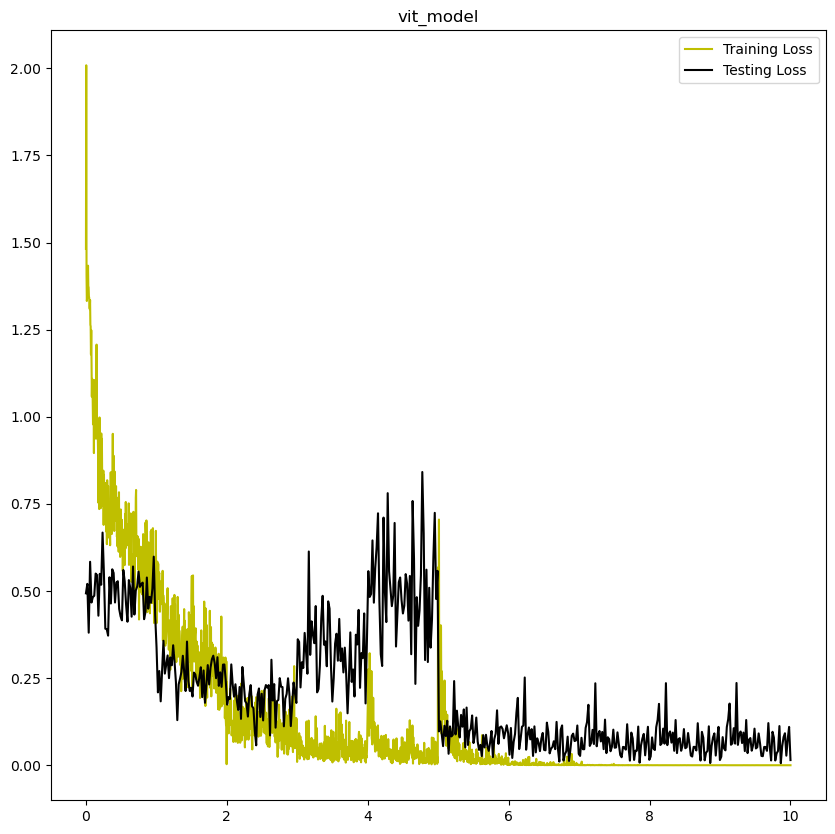

In [34]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_loss_logger))
plt.plot(valid_x, validation_loss_logger, c = "k")

plt.title("vit_model")
plt.legend(["Training Loss", "Testing Loss"])
plt.savefig("vit_model.png", dpi=300, bbox_inches='tight')

In [37]:
vit_model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = vit_model(inputs)
        probs = torch.softmax(outputs, dim=1)  # probabilities for AUC

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_probs = np.array(all_probs)

# Binarize the true labels for AUC calculation
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')

# Print metrics
print(f"VIT Model Accuracy:  {accuracy:.4f}")
print(f"VIT Model Precision: {precision:.4f}")
print(f"VIT Model Recall:    {recall:.4f}")
print(f"VIT Model F1 Score:  {f1:.4f}")
print(f"VIT Model AUC:       {auc:.4f}")

VIT Model Accuracy:  0.9795
VIT Model Precision: 0.9803
VIT Model Recall:    0.9802
VIT Model F1 Score:  0.9802
VIT Model AUC:       0.9988


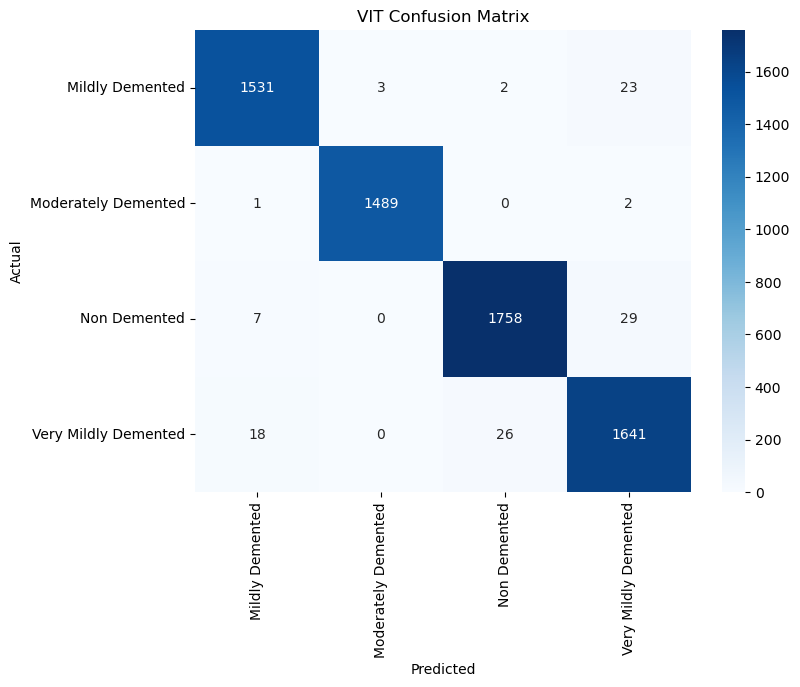

In [100]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
class_names = ['Mildly Demented', 'Moderately Demented', 'Non Demented', 'Very Mildly Demented']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('VIT Confusion Matrix')
plt.savefig("VIT.png", dpi=300, bbox_inches='tight') 
plt.show()